In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

2024-02-27 22:03:33.798296: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 22:03:33.798391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 22:03:33.984849: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def load_video(path:str) -> List[float]:
    cap=cv2.VideoCapture(path)
    frames=[]
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame=tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean=tf.math.reduce_mean(frames)
    std=tf.math.reduce_std(tf.cast(frames,tf.float32))
    return tf.cast((frames-mean),tf.float32)/std

In [3]:
path="/kaggle/input/lipreading/data/s1/bbaf2n.mpg"
value=load_video(path)
value

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[1.4991663 ],
         [1.4991663 ],
         [1.4616871 ],
         ...,
         [0.41227072],
         [0.41227072],
         [0.41227072]],

        [[1.4991663 ],
         [1.4991663 ],
         [1.4616871 ],
         ...,
         [0.41227072],
         [0.41227072],
         [0.41227072]],

        [[1.4616871 ],
         [1.4616871 ],
         [1.4991663 ],
         ...,
         [0.3373124 ],
         [0.3373124 ],
         [0.3373124 ]],

        ...,

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.11243746],
         [0.11243746],
         [0.07495831]],

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.11243746],
         [0.07495831],
         [0.07495831]],

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.07495831],
         [0.07495831],
         [0.03747915]]],


  

In [4]:
#ADDITIONAL FUNCTION I MADE TO GET vocab WHICH IS A PARAMETER FOR THE CHAR_TO_NUM FUNCTION
def get_vocab():
    vocab=[]
    
    directory="/kaggle/input/lipreading/data/alignments/s1"
    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        with open(file_path, 'r') as f:
            lines=f.readlines()
            for line in lines:
                line=line.split()
                vocab.append(line[2])
    return vocab  

In [5]:
vocab=np.unique(get_vocab())

In [6]:
char_to_num= tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char=tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="",invert=True)

In [7]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines=f.readlines()
        
            
        
    tokens=[]
    for line in lines:
        line=line.split()
        if line[2]!= 'sil':
            tokens= [*tokens,' ',line[2]]
        
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens,input_encoding='UTF-8'),(-1)))[1:]

In [8]:
path="/kaggle/input/lipreading/data/alignments/s1/bbaf2n.align"
load_alignments(path)

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 4, 18, 25,  0,  4, 22, 46, 10,  0,  1, 43,  0, 12,  0, 43,  0, 28,
        0, 25, 28,  0])>

In [9]:
def load_data(path:str):
    path=bytes.decode(path.numpy())
    file_name=path.split('/')[-1].split('.')[0]
    video_path=os.path.join('/kaggle/input/lipreading/data','s1',f'{file_name}.mpg')
    alignment_path=os.path.join('/kaggle/input/lipreading/data','alignments','s1',f'{file_name}.align')
    frames=load_video(video_path)
    alignments=load_alignments(alignment_path)
    
    return frames,alignments

In [10]:
#TESTING THE OUTPUT FOR A SAMPLE FILE
path="/kaggle/input/lipreading/data/s1/bbaf2n.mpg"
frames, alignments=load_data(tf.convert_to_tensor(path))
print("frames:",frames)
print("alignments:",alignments)

frames: tf.Tensor(
[[[[1.4991663 ]
   [1.4991663 ]
   [1.4616871 ]
   ...
   [0.41227072]
   [0.41227072]
   [0.41227072]]

  [[1.4991663 ]
   [1.4991663 ]
   [1.4616871 ]
   ...
   [0.41227072]
   [0.41227072]
   [0.41227072]]

  [[1.4616871 ]
   [1.4616871 ]
   [1.4991663 ]
   ...
   [0.3373124 ]
   [0.3373124 ]
   [0.3373124 ]]

  ...

  [[1.0494163 ]
   [1.0494163 ]
   [1.0119373 ]
   ...
   [0.11243746]
   [0.11243746]
   [0.07495831]]

  [[1.0494163 ]
   [1.0494163 ]
   [1.0119373 ]
   ...
   [0.11243746]
   [0.07495831]
   [0.07495831]]

  [[1.0494163 ]
   [1.0494163 ]
   [1.0119373 ]
   ...
   [0.07495831]
   [0.07495831]
   [0.03747915]]]


 [[[1.4242079 ]
   [1.4242079 ]
   [1.4242079 ]
   ...
   [0.3373124 ]
   [0.3373124 ]
   [0.3373124 ]]

  [[1.4242079 ]
   [1.4242079 ]
   [1.4242079 ]
   ...
   [0.3373124 ]
   [0.3373124 ]
   [0.3373124 ]]

  [[1.4242079 ]
   [1.4242079 ]
   [1.4242079 ]
   ...
   [0.29983324]
   [0.29983324]
   [0.29983324]]

  ...

  [[1.0494163 ]
   [

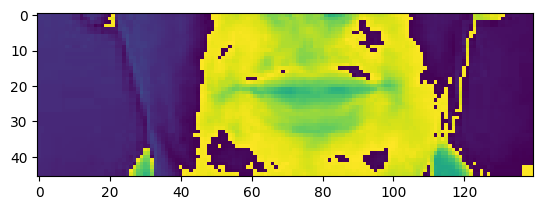

In [11]:
plt.imshow(frames[40])

In [12]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [13]:
data = tf.data.Dataset.list_files('/kaggle/input/lipreading/data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)

# Division des données en ensembles d'entraînement et de test
train_size = 450
train_data = data.take(train_size)
test_data = data.skip(train_size)

# Création des lots (batches) de données
train_data = train_data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
test_data = test_data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))

# Préchargement des données
train_data = train_data.prefetch(tf.data.AUTOTUNE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)


In [14]:
# data = tf.data.Dataset.list_files('/kaggle/input/lipreading/data/s1/*.mpg')
# data = data.shuffle(500,reshuffle_each_iteration=False)
# data = data.map(mappable_function)
# data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
# data = data.prefetch(tf.data.AUTOTUNE)
# # # ADDED DOR SPLIT
# train = data.take(450)
# test = data.skip(450)

In [15]:
# frames, alighnments = data.as_numpy_iterator().next()

In [16]:
sample = data.as_numpy_iterator()

In [17]:
val = sample.next();val[0]

array([[[[1.4777119 ],
         [1.4388248 ],
         [1.3999376 ],
         ...,
         [0.11666147],
         [0.11666147],
         [0.11666147]],

        [[1.4777119 ],
         [1.4388248 ],
         [1.3610505 ],
         ...,
         [0.11666147],
         [0.11666147],
         [0.11666147]],

        [[1.3610505 ],
         [1.3610505 ],
         [1.3610505 ],
         ...,
         [0.07777432],
         [0.07777432],
         [0.07777432]],

        ...,

        [[1.0499532 ],
         [1.0499532 ],
         [1.0110661 ],
         ...,
         [9.760676  ],
         [9.760676  ],
         [9.760676  ]],

        [[1.0499532 ],
         [1.0499532 ],
         [1.0110661 ],
         ...,
         [9.760676  ],
         [9.760676  ],
         [9.760676  ]],

        [[1.0499532 ],
         [1.0499532 ],
         [1.0110661 ],
         ...,
         [9.760676  ],
         [9.760676  ],
         [9.760676  ]]],


       [[[1.516599  ],
         [1.3999376 ],
         [1.39

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D,Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [19]:
def scheduler(epoch,lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [20]:
# class ProduceExample(tf.keras.callbacks.Callback):
#     def __init__(self, dataset) -> None:
#         self.dataset = dataset.as_numpy_iterator()
#     def on_epoch_end(self, epoch, logs=None) -> None:
#         data = self.dataset.next()
#         yhat = self.model.predict(data[0])
#         decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
#         for x in range(len(yhat)):
#             print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
#             print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
#             print('~'*100)

In [21]:
def CTCLoss(y_true,y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1],dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1],dtype="int64")
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, Activation, MaxPool3D, TimeDistributed, Flatten, Bidirectional, LSTM, Dropout, Dense, BatchNormalization

model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.35))
model.add(BatchNormalization())


model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.35))

model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))


In [23]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)
schedule_callback = LearningRateScheduler(scheduler)


In [24]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [25]:
history=model.fit(train_data,validation_data=test_data,epochs=80,callbacks=[checkpoint_callback,schedule_callback])

Epoch 1/80


I0000 00:00:1709071455.467160      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 44/225 [====>.........................] - ETA: 2:52 - loss: 255.1924

[mpeg1video @ 0x7978ac08df00] ac-tex damaged at 22 17
[mpeg1video @ 0x7978ac08df00] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 167.2529

[mpeg1video @ 0x797a040bdc80] ac-tex damaged at 22 17
[mpeg1video @ 0x797a040bdc80] Warning MVs not available


225/225 [==============================] - 527s 2s/step - loss: 167.2529 - val_loss: 143.0932 - lr: 1.0000e-04
Epoch 2/80
225/225 [==============================] - ETA: 0s - loss: 109.9492

[mpeg1video @ 0x7978dc022580] ac-tex damaged at 22 17
[mpeg1video @ 0x7978dc022580] Warning MVs not available


225/225 [==============================] - 492s 2s/step - loss: 109.9492 - val_loss: 96.3450 - lr: 1.0000e-04
Epoch 3/80
225/225 [==============================] - ETA: 0s - loss: 98.6087

[mpeg1video @ 0x7974f406cac0] ac-tex damaged at 22 17
[mpeg1video @ 0x7974f406cac0] Warning MVs not available


225/225 [==============================] - 492s 2s/step - loss: 98.6087 - val_loss: 88.5129 - lr: 1.0000e-04
Epoch 4/80
225/225 [==============================] - ETA: 0s - loss: 93.6032

[mpeg1video @ 0x7978dc05f940] ac-tex damaged at 22 17
[mpeg1video @ 0x7978dc05f940] Warning MVs not available


225/225 [==============================] - 488s 2s/step - loss: 93.6032 - val_loss: 85.9257 - lr: 1.0000e-04
Epoch 5/80
225/225 [==============================] - ETA: 0s - loss: 91.1129

[mpeg1video @ 0x7974fc055c80] ac-tex damaged at 22 17
[mpeg1video @ 0x7974fc055c80] Warning MVs not available


225/225 [==============================] - 484s 2s/step - loss: 91.1129 - val_loss: 83.2725 - lr: 1.0000e-04
Epoch 6/80
  4/225 [..............................] - ETA: 3:33 - loss: 86.5858

[mpeg1video @ 0x79789bb01d00] ac-tex damaged at 22 17
[mpeg1video @ 0x79789bb01d00] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 88.3057

[mpeg1video @ 0x7978d00d8180] ac-tex damaged at 22 17
[mpeg1video @ 0x7978d00d8180] Warning MVs not available


225/225 [==============================] - 486s 2s/step - loss: 88.3057 - val_loss: 83.3654 - lr: 1.0000e-04
Epoch 7/80
124/225 [===============>..............] - ETA: 1:35 - loss: 86.2183

[mpeg1video @ 0x7979d002b380] ac-tex damaged at 22 17
[mpeg1video @ 0x7979d002b380] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 85.8045

[mpeg1video @ 0x7974f40bd780] ac-tex damaged at 22 17
[mpeg1video @ 0x7974f40bd780] Warning MVs not available


225/225 [==============================] - 479s 2s/step - loss: 85.8045 - val_loss: 81.1436 - lr: 1.0000e-04
Epoch 8/80
225/225 [==============================] - ETA: 0s - loss: 84.9860

[mpeg1video @ 0x7978dc05d400] ac-tex damaged at 22 17
[mpeg1video @ 0x7978dc05d400] Warning MVs not available


225/225 [==============================] - 481s 2s/step - loss: 84.9860 - val_loss: 77.2862 - lr: 1.0000e-04
Epoch 9/80
188/225 [========================>.....] - ETA: 35s - loss: 83.1277

[mpeg1video @ 0x7979ec0bf000] ac-tex damaged at 22 17
[mpeg1video @ 0x7979ec0bf000] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 83.0777

[mpeg1video @ 0x79788805fc80] ac-tex damaged at 22 17
[mpeg1video @ 0x79788805fc80] Warning MVs not available


225/225 [==============================] - 479s 2s/step - loss: 83.0777 - val_loss: 78.7673 - lr: 1.0000e-04
Epoch 10/80
225/225 [==============================] - ETA: 0s - loss: 82.8543

[mpeg1video @ 0x7978d004b640] ac-tex damaged at 22 17
[mpeg1video @ 0x7978d004b640] Warning MVs not available


225/225 [==============================] - 477s 2s/step - loss: 82.8543 - val_loss: 75.3062 - lr: 1.0000e-04
Epoch 11/80
 26/225 [==>...........................] - ETA: 3:09 - loss: 79.2416

[mpeg1video @ 0x797908039140] ac-tex damaged at 22 17
[mpeg1video @ 0x797908039140] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 79.0990

[mpeg1video @ 0x7974f4054140] ac-tex damaged at 22 17
[mpeg1video @ 0x7974f4054140] Warning MVs not available


225/225 [==============================] - 481s 2s/step - loss: 79.0990 - val_loss: 71.0787 - lr: 1.0000e-04
Epoch 12/80
132/225 [================>.............] - ETA: 1:28 - loss: 76.5138

[mpeg1video @ 0x7974b6338380] ac-tex damaged at 22 17
[mpeg1video @ 0x7974b6338380] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 74.7280

[mpeg1video @ 0x7978d004cec0] ac-tex damaged at 22 17
[mpeg1video @ 0x7978d004cec0] Warning MVs not available


225/225 [==============================] - 477s 2s/step - loss: 74.7280 - val_loss: 68.4961 - lr: 1.0000e-04
Epoch 13/80
225/225 [==============================] - ETA: 0s - loss: 69.8420

[mpeg1video @ 0x7974fc065d40] ac-tex damaged at 22 17
[mpeg1video @ 0x7974fc065d40] Warning MVs not available


225/225 [==============================] - 477s 2s/step - loss: 69.8420 - val_loss: 61.3553 - lr: 1.0000e-04
Epoch 14/80
210/225 [===========================>..] - ETA: 14s - loss: 66.6233

[mpeg1video @ 0x7978a396af40] ac-tex damaged at 22 17
[mpeg1video @ 0x7978a396af40] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 66.5758

[mpeg1video @ 0x7978d01f1200] ac-tex damaged at 22 17
[mpeg1video @ 0x7978d01f1200] Warning MVs not available


225/225 [==============================] - 478s 2s/step - loss: 66.5758 - val_loss: 61.5324 - lr: 1.0000e-04
Epoch 15/80
225/225 [==============================] - ETA: 0s - loss: 62.5783

[mpeg1video @ 0x79788808d580] ac-tex damaged at 22 17
[mpeg1video @ 0x79788808d580] Warning MVs not available


225/225 [==============================] - 475s 2s/step - loss: 62.5783 - val_loss: 56.9226 - lr: 1.0000e-04
Epoch 16/80
225/225 [==============================] - ETA: 0s - loss: 61.6123

[mpeg1video @ 0x7978d40fda80] ac-tex damaged at 22 17
[mpeg1video @ 0x7978d40fda80] Warning MVs not available


225/225 [==============================] - 476s 2s/step - loss: 61.6123 - val_loss: 57.1402 - lr: 1.0000e-04
Epoch 17/80
225/225 [==============================] - ETA: 0s - loss: 60.2620

[mpeg1video @ 0x7974f4050b40] ac-tex damaged at 22 17
[mpeg1video @ 0x7974f4050b40] Warning MVs not available


225/225 [==============================] - 477s 2s/step - loss: 60.2620 - val_loss: 55.0890 - lr: 1.0000e-04
Epoch 18/80
225/225 [==============================] - ETA: 0s - loss: 58.2651

[mpeg1video @ 0x7978d0043180] ac-tex damaged at 22 17
[mpeg1video @ 0x7978d0043180] Warning MVs not available


225/225 [==============================] - 477s 2s/step - loss: 58.2651 - val_loss: 53.1247 - lr: 1.0000e-04
Epoch 19/80
162/225 [====================>.........] - ETA: 59s - loss: 56.9976 

[mpeg1video @ 0x79793000ec00] ac-tex damaged at 22 17
[mpeg1video @ 0x79793000ec00] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 57.0444

[mpeg1video @ 0x797888015f00] ac-tex damaged at 22 17
[mpeg1video @ 0x797888015f00] Warning MVs not available


225/225 [==============================] - 476s 2s/step - loss: 57.0444 - val_loss: 53.7645 - lr: 1.0000e-04
Epoch 20/80
209/225 [==========================>...] - ETA: 15s - loss: 57.2266

[mpeg1video @ 0x79789bba23c0] ac-tex damaged at 22 17
[mpeg1video @ 0x79789bba23c0] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 57.2327

[mpeg1video @ 0x7978dc036a40] ac-tex damaged at 22 17
[mpeg1video @ 0x7978dc036a40] Warning MVs not available


225/225 [==============================] - 477s 2s/step - loss: 57.2327 - val_loss: 52.0330 - lr: 1.0000e-04
Epoch 21/80
225/225 [==============================] - ETA: 0s - loss: 55.1983

[mpeg1video @ 0x7974f40a6fc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7974f40a6fc0] Warning MVs not available


225/225 [==============================] - 475s 2s/step - loss: 55.1983 - val_loss: 51.2129 - lr: 1.0000e-04
Epoch 22/80
225/225 [==============================] - ETA: 0s - loss: 54.0739

[mpeg1video @ 0x7978d00a6500] ac-tex damaged at 22 17
[mpeg1video @ 0x7978d00a6500] Warning MVs not available


225/225 [==============================] - 476s 2s/step - loss: 54.0739 - val_loss: 48.6868 - lr: 1.0000e-04
Epoch 23/80
225/225 [==============================] - ETA: 0s - loss: 51.8381

[mpeg1video @ 0x7974fc0ca980] ac-tex damaged at 22 17
[mpeg1video @ 0x7974fc0ca980] Warning MVs not available


225/225 [==============================] - 476s 2s/step - loss: 51.8381 - val_loss: 47.1507 - lr: 1.0000e-04
Epoch 24/80
225/225 [==============================] - ETA: 0s - loss: 50.9702

[mpeg1video @ 0x7978d8022d00] ac-tex damaged at 22 17
[mpeg1video @ 0x7978d8022d00] Warning MVs not available


225/225 [==============================] - 475s 2s/step - loss: 50.9702 - val_loss: 44.2491 - lr: 1.0000e-04
Epoch 25/80
225/225 [==============================] - ETA: 0s - loss: 48.4346

[mpeg1video @ 0x5589fd4da0c0] ac-tex damaged at 22 17
[mpeg1video @ 0x5589fd4da0c0] Warning MVs not available


225/225 [==============================] - 476s 2s/step - loss: 48.4346 - val_loss: 42.6576 - lr: 1.0000e-04
Epoch 26/80
225/225 [==============================] - ETA: 0s - loss: 46.4973

[mpeg1video @ 0x7978d800bcc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7978d800bcc0] Warning MVs not available


225/225 [==============================] - 477s 2s/step - loss: 46.4973 - val_loss: 43.4245 - lr: 1.0000e-04
Epoch 27/80
225/225 [==============================] - ETA: 0s - loss: 43.9137

[mpeg1video @ 0x5589fdabb100] ac-tex damaged at 22 17
[mpeg1video @ 0x5589fdabb100] Warning MVs not available


225/225 [==============================] - 476s 2s/step - loss: 43.9137 - val_loss: 38.0657 - lr: 1.0000e-04
Epoch 28/80
225/225 [==============================] - ETA: 0s - loss: 41.6622

[mpeg1video @ 0x7978d8028c00] ac-tex damaged at 22 17
[mpeg1video @ 0x7978d8028c00] Warning MVs not available


225/225 [==============================] - 477s 2s/step - loss: 41.6622 - val_loss: 40.9463 - lr: 1.0000e-04
Epoch 29/80
225/225 [==============================] - ETA: 0s - loss: 39.8509

[mpeg1video @ 0x7974f404b7c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7974f404b7c0] Warning MVs not available


225/225 [==============================] - 475s 2s/step - loss: 39.8509 - val_loss: 32.7205 - lr: 1.0000e-04
Epoch 30/80
225/225 [==============================] - ETA: 0s - loss: 37.7998

[mpeg1video @ 0x7978dc0ba2c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7978dc0ba2c0] Warning MVs not available


225/225 [==============================] - 476s 2s/step - loss: 37.7998 - val_loss: 33.5791 - lr: 1.0000e-04
Epoch 31/80
225/225 [==============================] - ETA: 0s - loss: 35.4170

[mpeg1video @ 0x79749e549d00] ac-tex damaged at 22 17
[mpeg1video @ 0x79749e549d00] Warning MVs not available


225/225 [==============================] - 477s 2s/step - loss: 35.4170 - val_loss: 28.7506 - lr: 9.0484e-05
Epoch 32/80
225/225 [==============================] - ETA: 0s - loss: 34.0460

[mpeg1video @ 0x79790804b800] ac-tex damaged at 22 17
[mpeg1video @ 0x79790804b800] Warning MVs not available


225/225 [==============================] - 475s 2s/step - loss: 34.0460 - val_loss: 27.4827 - lr: 8.1873e-05
Epoch 33/80
 88/225 [==========>...................] - ETA: 2:08 - loss: 32.6315

[mpeg1video @ 0x7979f4203f80] ac-tex damaged at 22 17
[mpeg1video @ 0x7979f4203f80] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 32.1340

[mpeg1video @ 0x79749e6aeb40] ac-tex damaged at 22 17
[mpeg1video @ 0x79749e6aeb40] Warning MVs not available


225/225 [==============================] - 476s 2s/step - loss: 32.1340 - val_loss: 25.6566 - lr: 7.4082e-05
Epoch 34/80
113/225 [==============>...............] - ETA: 1:45 - loss: 29.8780

[mpeg1video @ 0x7978ac033740] ac-tex damaged at 22 17
[mpeg1video @ 0x7978ac033740] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 30.5401

[mpeg1video @ 0x797930080000] ac-tex damaged at 22 17
[mpeg1video @ 0x797930080000] Warning MVs not available


225/225 [==============================] - 475s 2s/step - loss: 30.5401 - val_loss: 26.1001 - lr: 6.7032e-05
Epoch 35/80
225/225 [==============================] - ETA: 0s - loss: 28.6310

[mpeg1video @ 0x797884065240] ac-tex damaged at 22 17
[mpeg1video @ 0x797884065240] Warning MVs not available


225/225 [==============================] - 477s 2s/step - loss: 28.6310 - val_loss: 23.2186 - lr: 6.0653e-05
Epoch 36/80
225/225 [==============================] - ETA: 0s - loss: 27.7186

[mpeg1video @ 0x79793001ec80] ac-tex damaged at 22 17
[mpeg1video @ 0x79793001ec80] Warning MVs not available


225/225 [==============================] - 478s 2s/step - loss: 27.7186 - val_loss: 22.6523 - lr: 5.4881e-05
Epoch 37/80
  2/225 [..............................] - ETA: 3:32 - loss: 27.5372

[mpeg1video @ 0x7979fc08e440] ac-tex damaged at 22 17
[mpeg1video @ 0x7979fc08e440] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 26.3473

[mpeg1video @ 0x79789bc76140] ac-tex damaged at 22 17
[mpeg1video @ 0x79789bc76140] Warning MVs not available


225/225 [==============================] - 475s 2s/step - loss: 26.3473 - val_loss: 20.6127 - lr: 4.9659e-05
Epoch 38/80
124/225 [===============>..............] - ETA: 1:34 - loss: 25.0858

[mpeg1video @ 0x7978ac05dcc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7978ac05dcc0] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 25.3872

[mpeg1video @ 0x797908006a80] ac-tex damaged at 22 17
[mpeg1video @ 0x797908006a80] Warning MVs not available


225/225 [==============================] - 474s 2s/step - loss: 25.3872 - val_loss: 20.0129 - lr: 4.4933e-05
Epoch 39/80
225/225 [==============================] - ETA: 0s - loss: 24.2948

[mpeg1video @ 0x79749dfbed80] ac-tex damaged at 22 17
[mpeg1video @ 0x79749dfbed80] Warning MVs not available


225/225 [==============================] - 477s 2s/step - loss: 24.2948 - val_loss: 18.4202 - lr: 4.0657e-05
Epoch 40/80
187/225 [=======================>......] - ETA: 35s - loss: 23.1012

[mpeg1video @ 0x79789c09bc40] ac-tex damaged at 22 17
[mpeg1video @ 0x79789c09bc40] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 22.9850

[mpeg1video @ 0x7978e006e900] ac-tex damaged at 22 17
[mpeg1video @ 0x7978e006e900] Warning MVs not available


225/225 [==============================] - 474s 2s/step - loss: 22.9850 - val_loss: 18.3930 - lr: 3.6788e-05
Epoch 41/80
225/225 [==============================] - ETA: 0s - loss: 22.0662

[mpeg1video @ 0x79749e409d40] ac-tex damaged at 22 17
[mpeg1video @ 0x79749e409d40] Warning MVs not available


225/225 [==============================] - 473s 2s/step - loss: 22.0662 - val_loss: 17.1467 - lr: 3.3287e-05
Epoch 42/80
225/225 [==============================] - ETA: 0s - loss: 21.7175

[mpeg1video @ 0x7978e0099a00] ac-tex damaged at 22 17
[mpeg1video @ 0x7978e0099a00] Warning MVs not available


225/225 [==============================] - 473s 2s/step - loss: 21.7175 - val_loss: 16.5565 - lr: 3.0119e-05
Epoch 43/80
225/225 [==============================] - ETA: 0s - loss: 20.9166

[mpeg1video @ 0x79789b861e00] ac-tex damaged at 22 17
[mpeg1video @ 0x79789b861e00] Warning MVs not available


225/225 [==============================] - 473s 2s/step - loss: 20.9166 - val_loss: 15.9220 - lr: 2.7253e-05
Epoch 44/80
177/225 [======================>.......] - ETA: 44s - loss: 20.1741

[mpeg1video @ 0x79789c0c7080] ac-tex damaged at 22 17
[mpeg1video @ 0x79789c0c7080] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 20.0270

[mpeg1video @ 0x7979300aee00] ac-tex damaged at 22 17
[mpeg1video @ 0x7979300aee00] Warning MVs not available


225/225 [==============================] - 471s 2s/step - loss: 20.0270 - val_loss: 15.3758 - lr: 2.4660e-05
Epoch 45/80
215/225 [===========================>..] - ETA: 9s - loss: 19.6876 

[mpeg1video @ 0x797a08048d40] ac-tex damaged at 22 17
[mpeg1video @ 0x797a08048d40] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 19.7693

[mpeg1video @ 0x79789bd4ffc0] ac-tex damaged at 22 17
[mpeg1video @ 0x79789bd4ffc0] Warning MVs not available


225/225 [==============================] - 475s 2s/step - loss: 19.7693 - val_loss: 14.9720 - lr: 2.2313e-05
Epoch 46/80
 50/225 [=====>........................] - ETA: 2:44 - loss: 19.0612

[mpeg1video @ 0x7978a8bb0c80] ac-tex damaged at 22 17
[mpeg1video @ 0x7978a8bb0c80] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 19.2791

[mpeg1video @ 0x7979300146c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7979300146c0] Warning MVs not available


225/225 [==============================] - 474s 2s/step - loss: 19.2791 - val_loss: 14.5523 - lr: 2.0190e-05
Epoch 47/80
225/225 [==============================] - ETA: 0s - loss: 18.9435

[mpeg1video @ 0x79789b316a00] ac-tex damaged at 22 17
[mpeg1video @ 0x79789b316a00] Warning MVs not available


225/225 [==============================] - 473s 2s/step - loss: 18.9435 - val_loss: 13.3349 - lr: 1.8268e-05
Epoch 48/80
225/225 [==============================] - ETA: 0s - loss: 18.6261

[mpeg1video @ 0x7978e00a2880] ac-tex damaged at 22 17
[mpeg1video @ 0x7978e00a2880] Warning MVs not available


225/225 [==============================] - 473s 2s/step - loss: 18.6261 - val_loss: 13.4022 - lr: 1.6530e-05
Epoch 49/80
225/225 [==============================] - ETA: 0s - loss: 17.6310

[mpeg1video @ 0x79789bb02980] ac-tex damaged at 22 17
[mpeg1video @ 0x79789bb02980] Warning MVs not available


225/225 [==============================] - 475s 2s/step - loss: 17.6310 - val_loss: 12.5694 - lr: 1.4957e-05
Epoch 50/80
225/225 [==============================] - ETA: 0s - loss: 18.0936

[mpeg1video @ 0x7978e0011100] ac-tex damaged at 22 17
[mpeg1video @ 0x7978e0011100] Warning MVs not available


225/225 [==============================] - 472s 2s/step - loss: 18.0936 - val_loss: 12.7285 - lr: 1.3534e-05
Epoch 51/80
225/225 [==============================] - ETA: 0s - loss: 17.1447

[mpeg1video @ 0x79789b934ec0] ac-tex damaged at 22 17
[mpeg1video @ 0x79789b934ec0] Warning MVs not available


225/225 [==============================] - 471s 2s/step - loss: 17.1447 - val_loss: 12.4674 - lr: 1.2246e-05
Epoch 52/80
115/225 [==============>...............] - ETA: 1:42 - loss: 17.2431

[mpeg1video @ 0x7978ac07a2c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7978ac07a2c0] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 17.0809

[mpeg1video @ 0x7978e00c7280] ac-tex damaged at 22 17
[mpeg1video @ 0x7978e00c7280] Warning MVs not available


225/225 [==============================] - 473s 2s/step - loss: 17.0809 - val_loss: 11.9566 - lr: 1.1080e-05
Epoch 53/80
225/225 [==============================] - ETA: 0s - loss: 17.0594

[mpeg1video @ 0x797890067440] ac-tex damaged at 22 17
[mpeg1video @ 0x797890067440] Warning MVs not available


225/225 [==============================] - 476s 2s/step - loss: 17.0594 - val_loss: 11.8278 - lr: 1.0026e-05
Epoch 54/80
225/225 [==============================] - ETA: 0s - loss: 16.4845

[mpeg1video @ 0x79790c075780] ac-tex damaged at 22 17
[mpeg1video @ 0x79790c075780] Warning MVs not available


225/225 [==============================] - 474s 2s/step - loss: 16.4845 - val_loss: 11.7136 - lr: 9.0718e-06
Epoch 55/80
225/225 [==============================] - ETA: 0s - loss: 16.4885

[mpeg1video @ 0x79749e8091c0] ac-tex damaged at 22 17
[mpeg1video @ 0x79749e8091c0] Warning MVs not available


225/225 [==============================] - 476s 2s/step - loss: 16.4885 - val_loss: 11.6237 - lr: 8.2085e-06
Epoch 56/80
 93/225 [===========>..................] - ETA: 2:03 - loss: 16.3461

[mpeg1video @ 0x7978a8ba9380] ac-tex damaged at 22 17
[mpeg1video @ 0x7978a8ba9380] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 16.3200

[mpeg1video @ 0x79790c0d5dc0] ac-tex damaged at 22 17
[mpeg1video @ 0x79790c0d5dc0] Warning MVs not available


225/225 [==============================] - 472s 2s/step - loss: 16.3200 - val_loss: 11.4037 - lr: 7.4273e-06
Epoch 57/80
 70/225 [========>.....................] - ETA: 2:24 - loss: 16.5508

[mpeg1video @ 0x7979f4068a00] ac-tex damaged at 22 17
[mpeg1video @ 0x7979f4068a00] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 16.0151

[mpeg1video @ 0x79749e81e940] ac-tex damaged at 22 17
[mpeg1video @ 0x79749e81e940] Warning MVs not available


225/225 [==============================] - 471s 2s/step - loss: 16.0151 - val_loss: 11.3120 - lr: 6.7205e-06
Epoch 58/80
215/225 [===========================>..] - ETA: 9s - loss: 15.7183 

[mpeg1video @ 0x79789c006a80] ac-tex damaged at 22 17
[mpeg1video @ 0x79789c006a80] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 15.7413

[mpeg1video @ 0x7979300c5580] ac-tex damaged at 22 17
[mpeg1video @ 0x7979300c5580] Warning MVs not available


225/225 [==============================] - 470s 2s/step - loss: 15.7413 - val_loss: 11.0229 - lr: 6.0810e-06
Epoch 59/80
131/225 [================>.............] - ETA: 1:27 - loss: 16.0381

[mpeg1video @ 0x7979f40d4fc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7979f40d4fc0] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 16.0784

[mpeg1video @ 0x79789007a180] ac-tex damaged at 22 17
[mpeg1video @ 0x79789007a180] Warning MVs not available


225/225 [==============================] - 470s 2s/step - loss: 16.0784 - val_loss: 11.1434 - lr: 5.5023e-06
Epoch 60/80
225/225 [==============================] - ETA: 0s - loss: 15.6939

[mpeg1video @ 0x797908096400] ac-tex damaged at 22 17
[mpeg1video @ 0x797908096400] Warning MVs not available


225/225 [==============================] - 472s 2s/step - loss: 15.6939 - val_loss: 11.0150 - lr: 4.9787e-06
Epoch 61/80
225/225 [==============================] - ETA: 0s - loss: 15.5699

[mpeg1video @ 0x79789bb10980] ac-tex damaged at 22 17
[mpeg1video @ 0x79789bb10980] Warning MVs not available


225/225 [==============================] - 476s 2s/step - loss: 15.5699 - val_loss: 11.0474 - lr: 4.5049e-06
Epoch 62/80
225/225 [==============================] - ETA: 0s - loss: 15.1582

[mpeg1video @ 0x797930094040] ac-tex damaged at 22 17
[mpeg1video @ 0x797930094040] Warning MVs not available


225/225 [==============================] - 487s 2s/step - loss: 15.1582 - val_loss: 10.5184 - lr: 4.0762e-06
Epoch 63/80
 40/225 [====>.........................] - ETA: 2:59 - loss: 15.8698

[mpeg1video @ 0x797a0805d800] ac-tex damaged at 22 17
[mpeg1video @ 0x797a0805d800] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 15.3282

[mpeg1video @ 0x79789bbd4e80] ac-tex damaged at 22 17
[mpeg1video @ 0x79789bbd4e80] Warning MVs not available


225/225 [==============================] - 485s 2s/step - loss: 15.3282 - val_loss: 10.8324 - lr: 3.6883e-06
Epoch 64/80
225/225 [==============================] - ETA: 0s - loss: 15.0872

[mpeg1video @ 0x7979080a9e40] ac-tex damaged at 22 17
[mpeg1video @ 0x7979080a9e40] Warning MVs not available


225/225 [==============================] - 481s 2s/step - loss: 15.0872 - val_loss: 10.6270 - lr: 3.3373e-06
Epoch 65/80
223/225 [============================>.] - ETA: 1s - loss: 15.0937

[mpeg1video @ 0x7979fc044500] ac-tex damaged at 22 17
[mpeg1video @ 0x7979fc044500] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 15.1238

[mpeg1video @ 0x79749e62c140] ac-tex damaged at 22 17
[mpeg1video @ 0x79749e62c140] Warning MVs not available


225/225 [==============================] - 478s 2s/step - loss: 15.1238 - val_loss: 10.6377 - lr: 3.0197e-06
Epoch 66/80
225/225 [==============================] - ETA: 0s - loss: 14.9690

[mpeg1video @ 0x79790c00b580] ac-tex damaged at 22 17
[mpeg1video @ 0x79790c00b580] Warning MVs not available


225/225 [==============================] - 470s 2s/step - loss: 14.9690 - val_loss: 10.4683 - lr: 2.7324e-06
Epoch 67/80
213/225 [===========================>..] - ETA: 11s - loss: 14.9862

[mpeg1video @ 0x797a00063700] ac-tex damaged at 22 17
[mpeg1video @ 0x797a00063700] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 14.9899

[mpeg1video @ 0x79789005c5c0] ac-tex damaged at 22 17
[mpeg1video @ 0x79789005c5c0] Warning MVs not available


225/225 [==============================] - 472s 2s/step - loss: 14.9899 - val_loss: 10.1670 - lr: 2.4723e-06
Epoch 68/80
225/225 [==============================] - ETA: 0s - loss: 14.8318

[mpeg1video @ 0x7978e000bd40] ac-tex damaged at 22 17
[mpeg1video @ 0x7978e000bd40] Warning MVs not available


225/225 [==============================] - 468s 2s/step - loss: 14.8318 - val_loss: 10.4424 - lr: 2.2371e-06
Epoch 69/80
159/225 [====================>.........] - ETA: 1:01 - loss: 14.6379

[mpeg1video @ 0x797a00002180] ac-tex damaged at 22 17
[mpeg1video @ 0x797a00002180] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 14.6429

[mpeg1video @ 0x79749e415500] ac-tex damaged at 22 17
[mpeg1video @ 0x79749e415500] Warning MVs not available


225/225 [==============================] - 469s 2s/step - loss: 14.6429 - val_loss: 10.2474 - lr: 2.0242e-06
Epoch 70/80
 32/225 [===>..........................] - ETA: 2:59 - loss: 14.4078

[mpeg1video @ 0x7978ac032080] ac-tex damaged at 22 17
[mpeg1video @ 0x7978ac032080] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 14.6239

[mpeg1video @ 0x79793009fa80] ac-tex damaged at 22 17
[mpeg1video @ 0x79793009fa80] Warning MVs not available


225/225 [==============================] - 469s 2s/step - loss: 14.6239 - val_loss: 10.2569 - lr: 1.8316e-06
Epoch 71/80
225/225 [==============================] - ETA: 0s - loss: 14.9434

[mpeg1video @ 0x797890006280] ac-tex damaged at 22 17
[mpeg1video @ 0x797890006280] Warning MVs not available


225/225 [==============================] - 469s 2s/step - loss: 14.9434 - val_loss: 10.1764 - lr: 1.6573e-06
Epoch 72/80
190/225 [========================>.....] - ETA: 32s - loss: 14.8035

[mpeg1video @ 0x79789c036880] ac-tex damaged at 22 17
[mpeg1video @ 0x79789c036880] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 14.8562

[mpeg1video @ 0x79793000afc0] ac-tex damaged at 22 17
[mpeg1video @ 0x79793000afc0] Warning MVs not available


225/225 [==============================] - 469s 2s/step - loss: 14.8562 - val_loss: 10.3916 - lr: 1.4996e-06
Epoch 73/80
164/225 [====================>.........] - ETA: 56s - loss: 14.8108

[mpeg1video @ 0x797a0004c680] ac-tex damaged at 22 17
[mpeg1video @ 0x797a0004c680] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 14.6930

[mpeg1video @ 0x79789b0e0dc0] ac-tex damaged at 22 17
[mpeg1video @ 0x79789b0e0dc0] Warning MVs not available


225/225 [==============================] - 470s 2s/step - loss: 14.6930 - val_loss: 9.9878 - lr: 1.3569e-06
Epoch 74/80
225/225 [==============================] - ETA: 0s - loss: 15.2296

[mpeg1video @ 0x79790c0756c0] ac-tex damaged at 22 17
[mpeg1video @ 0x79790c0756c0] Warning MVs not available


225/225 [==============================] - 468s 2s/step - loss: 15.2296 - val_loss: 10.1594 - lr: 1.2277e-06
Epoch 75/80
160/225 [====================>.........] - ETA: 1:00 - loss: 14.6281

[mpeg1video @ 0x797a080bd340] ac-tex damaged at 22 17
[mpeg1video @ 0x797a080bd340] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 14.9251

[mpeg1video @ 0x79789b940f00] ac-tex damaged at 22 17
[mpeg1video @ 0x79789b940f00] Warning MVs not available


225/225 [==============================] - 468s 2s/step - loss: 14.9251 - val_loss: 10.0959 - lr: 1.1109e-06
Epoch 76/80
225/225 [==============================] - ETA: 0s - loss: 14.5929

[mpeg1video @ 0x7979300a3140] ac-tex damaged at 22 17
[mpeg1video @ 0x7979300a3140] Warning MVs not available


225/225 [==============================] - 467s 2s/step - loss: 14.5929 - val_loss: 10.1885 - lr: 1.0052e-06
Epoch 77/80
225/225 [==============================] - ETA: 0s - loss: 14.8638

[mpeg1video @ 0x79789b737b80] ac-tex damaged at 22 17
[mpeg1video @ 0x79789b737b80] Warning MVs not available


225/225 [==============================] - 469s 2s/step - loss: 14.8638 - val_loss: 10.3952 - lr: 9.0953e-07
Epoch 78/80
128/225 [================>.............] - ETA: 1:30 - loss: 14.8955

[mpeg1video @ 0x79789c0773c0] ac-tex damaged at 22 17
[mpeg1video @ 0x79789c0773c0] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 14.6879

[mpeg1video @ 0x79790c026800] ac-tex damaged at 22 17
[mpeg1video @ 0x79790c026800] Warning MVs not available


225/225 [==============================] - 468s 2s/step - loss: 14.6879 - val_loss: 10.0540 - lr: 8.2297e-07
Epoch 79/80
225/225 [==============================] - ETA: 0s - loss: 14.2867

[mpeg1video @ 0x79749e7223c0] ac-tex damaged at 22 17
[mpeg1video @ 0x79749e7223c0] Warning MVs not available


225/225 [==============================] - 469s 2s/step - loss: 14.2867 - val_loss: 10.0638 - lr: 7.4466e-07
Epoch 80/80
225/225 [==============================] - ETA: 0s - loss: 14.7048

[mpeg1video @ 0x7979300a6f40] ac-tex damaged at 22 17
[mpeg1video @ 0x7979300a6f40] Warning MVs not available


225/225 [==============================] - 467s 2s/step - loss: 14.7048 - val_loss: 10.0341 - lr: 6.7379e-07


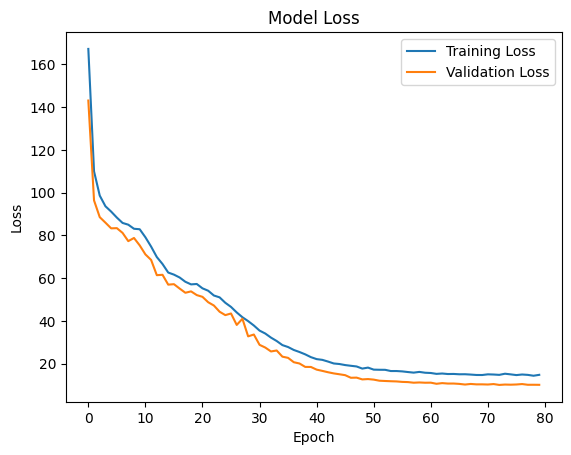

In [26]:
from matplotlib import pyplot as plt
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
# from tensorflow.python.ops.numpy_ops import np_config
# np_config.enable_numpy_behavior()
# # Load data from the file path
# frames, alignments = load_data(tf.convert_to_tensor(path))

# # Ensure the data matches the expected input shape
# frames = tf.reshape(frames, (1, 75, 46, 140, 1))

# # Predict using the model
# predictions = model.predict(frames)


In [28]:
# class AccuracyMetrics(tf.keras.callbacks.Callback):
#     def __init__(self, dataset) -> None:
#         self.dataset = dataset.as_numpy_iterator()
#         self.predictions = []
#         self.ground_truth = []

#     def on_epoch_end(self, epoch, logs=None) -> None:
#         data = self.dataset.next()
#         yhat = self.model.predict(data[0])
#         decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()
#         self.predictions.extend(decoded)
#         self.ground_truth.extend(data[1])

# # ... (your previous code)

# accuracy_metrics = AccuracyMetrics(test)  # Create an instance of AccuracyMetrics

# model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback, accuracy_metrics])

# # After training, compute accuracy or any other metric using predictions and ground truth
# predictions = accuracy_metrics.predictions
# ground_truth = accuracy_metrics.ground_truth

# # Compute accuracy (or any other suitable metric) here
# # For example, using sequence_accuracy from Levenshtein distance:
# from nltk.metrics.distance import edit_distance

# def compute_accuracy(preds, truths):
#     acc = sum(edit_distance(pred, truth) for pred, truth in zip(preds, truths)) / len(preds)
#     return 1 - acc

# accuracy = compute_accuracy(predictions, ground_truth)
# print("Accuracy:", accuracy)


In [29]:
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from nltk.metrics.distance import edit_distance

# # Définir une classe de rappel pour calculer et enregistrer l'accuracy à chaque époque
# class AccuracyCallback(tf.keras.callbacks.Callback):
#     def __init__(self, validation_data):
#         self.validation_data = validation_data.prefetch(tf.data.AUTOTUNE).as_numpy_iterator()
#         self.accuracies = []

#     def on_epoch_end(self, epoch, logs=None):
#         data = next(self.validation_data)
#         predictions = self.model.predict(data[0])
#         decoded = tf.keras.backend.ctc_decode(predictions, [75, 75], greedy=False)[0][0].numpy()
#         ground_truth = data[1]

#         accuracy = compute_accuracy(decoded, ground_truth)
#         print(f'Accuracy at epoch {epoch + 1}: {accuracy * 100:.2f}%')
#         self.accuracies.append(accuracy)

# # Fonction pour calculer l'accuracy
# def compute_accuracy(preds, truths):
#     acc = sum(edit_distance(pred, truth) for pred, truth in zip(preds, truths)) / len(preds)
#     return 1 - acc

# # Chargement des données
# data = tf.data.Dataset.list_files('/kaggle/input/lipreading/data/s1/*.mpg')
# data = data.shuffle(500, reshuffle_each_iteration=False)
# data = data.map(mappable_function)

# # Division des données en ensembles d'entraînement et de test
# train_size = 450
# train_data = data.take(train_size)
# test_data = data.skip(train_size)

# # Création des lots (batches) de données
# train_data = train_data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
# test_data = test_data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))

# # Préchargement des données
# train_data = train_data.prefetch(tf.data.AUTOTUNE)
# test_data = test_data.prefetch(tf.data.AUTOTUNE)

# # Utiliser la fonction de perte CTCLoss avec le rappel AccuracyCallback
# model.compile(optimizer='adam', loss=CTCLoss)
# accuracy_callback = AccuracyCallback(validation_data=test_data)  # Utiliser l'ensemble de test

# history = model.fit(train_data, validation_data=test_data, epochs=51, callbacks=[accuracy_callback])

# # Plotter les courbes d'accuracy
# plt.plot(accuracy_callback.accuracies, label='Validation Accuracy')
# plt.xlabel('Nombre d\'époques')
# plt.ylabel('Accuracy')
# plt.title('Évolution de l\'accuracy pendant l\'entraînement')
# plt.legend()
# plt.show()


In [30]:
# class AccuracyCallback(tf.keras.callbacks.Callback):
#     def __init__(self, validation_data):
#         self.validation_data = validation_data.prefetch(tf.data.AUTOTUNE).as_numpy_iterator()
#         self.accuracies = []

#     def on_epoch_end(self, epoch, logs=None):
#         data = next(self.validation_data)
#         predictions = self.model.predict(data[0])
#         decoded = tf.keras.backend.ctc_decode(predictions, [75, 75], greedy=False)[0][0].numpy()
#         ground_truth = data[1]

#         accuracy = compute_accuracy(decoded, ground_truth)
#         print(f'Accuracy at epoch {epoch + 1}: {accuracy * 100:.2f}%')
#         self.accuracies.append(accuracy)

# # Fonction pour calculer l'accuracy
# def compute_accuracy(preds, truths):
#     total_samples = len(preds)
#     correct_samples = sum(1 for pred, truth in zip(preds, truths) if pred == truth)
#     accuracy = correct_samples / total_samples
#     return accuracy

In [31]:
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from nltk.metrics.distance import edit_distance

# # Définir une classe de rappel pour calculer et enregistrer l'accuracy à chaque époque
# class AccuracyCallback(tf.keras.callbacks.Callback):
#     def __init__(self, validation_data, training_data):
#         self.validation_data = validation_data.prefetch(tf.data.AUTOTUNE).as_numpy_iterator()
#         self.training_data = training_data.prefetch(tf.data.AUTOTUNE).as_numpy_iterator()
#         self.accuracies = []
#         self.training_accuracies = []  # Nouvelle liste pour l'accuracy d'entraînement
#         self.training_losses = []      # Nouvelle liste pour la perte d'entraînement

#     def on_epoch_end(self, epoch, logs=None):
#         # Validation Accuracy
#         validation_data = next(self.validation_data)
#         predictions = self.model.predict(validation_data[0])
#         decoded = tf.keras.backend.ctc_decode(predictions, [75, 75], greedy=False)[0][0].numpy()
#         ground_truth = validation_data[1]

#         accuracy = compute_accuracy(decoded, ground_truth)
#         print(f'Validation Accuracy at epoch {epoch + 1}: {accuracy * 100:.2f}%')
#         self.accuracies.append(accuracy)

#         # Training Accuracy and Loss
#         training_data = next(self.training_data)
#         training_predictions = self.model.predict(training_data[0])
#         training_decoded = tf.keras.backend.ctc_decode(training_predictions, [75, 75], greedy=False)[0][0].numpy()
#         training_ground_truth = training_data[1]

#         training_accuracy = compute_accuracy(training_decoded, training_ground_truth)
#         training_loss = self.model.evaluate(training_data[0], training_data[1], verbose=0)

#         print(f'Training Accuracy at epoch {epoch + 1}: {training_accuracy }')
#         print(f'Training Loss at epoch {epoch + 1}: {training_loss}')

#         self.training_accuracies.append(training_accuracy)
#         self.training_losses.append(training_loss)

# # Fonction pour calculer l'accuracy
# def compute_accuracy(preds, truths):
#     acc = sum(edit_distance(pred, truth) for pred, truth in zip(preds, truths)) / len(preds)
#     return (1 - acc)

# # Chargement des données
# data = tf.data.Dataset.list_files('/kaggle/input/lipreading/data/s1/*.mpg')
# data = data.shuffle(500, reshuffle_each_iteration=False)
# data = data.map(mappable_function)

# # Division des données en ensembles d'entraînement et de test
# train_size = 450
# train_data = data.take(train_size)
# test_data = data.skip(train_size)

# # Création des lots (batches) de données
# train_data = train_data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
# test_data = test_data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))

# # Préchargement des données
# train_data = train_data.prefetch(tf.data.AUTOTUNE)
# test_data = test_data.prefetch(tf.data.AUTOTUNE)
# # Utiliser la fonction de perte CTCLoss avec le rappel AccuracyCallback
# # model.compile(optimizer='adam', loss=CTCLoss)
# # accuracy_callback = AccuracyCallback(validation_data=test_data, training_data=train_data)  # Utiliser l'ensemble de test et d'entraînement

# # history = model.fit(train_data, validation_data=test_data, epochs=1, callbacks=[accuracy_callback])

# # # Plotter les courbes d'accuracy
# # plt.plot(accuracy_callback.accuracies, label='Validation Accuracy')
# # plt.plot(accuracy_callback.training_accuracies, label='Training Accuracy')  # Nouvelle courbe pour l'accuracy d'entraînement
# # plt.xlabel('Nombre d\'époques')
# # plt.ylabel('Accuracy')
# # plt.title('Évolution de l\'accuracy pendant l\'entraînement')
# # plt.legend()
# # plt.show()

# # # Plotter les courbes de perte
# # plt.plot(history.history['loss'], label='Training Loss')  # Utilise les informations de history pour la perte d'entraînement
# # plt.xlabel('Nombre d\'époques')
# # plt.ylabel('Perte')
# # plt.title('Évolution de la perte d\'entraînement pendant l\'entraînement')
# # plt.legend()
# # plt.show()
# # Utiliser la fonction de perte CTCLoss avec le rappel AccuracyCallback
# model.compile(optimizer='adam', loss=CTCLoss)
# accuracy_callback = AccuracyCallback(validation_data=test_data)  # Utiliser l'ensemble de test

# history = model.fit(train_data, validation_data=test_data, epochs=1, callbacks=[accuracy_callback])

# # Plotter les courbes d'accuracy
# plt.plot(accuracy_callback.accuracies, label='Validation Accuracy')
# plt.xlabel('Nombre d\'époques')
# plt.ylabel('Accuracy')
# plt.title('Évolution de l\'accuracy pendant l\'entraînement')
# plt.legend()
# plt.show()

In [32]:
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from nltk.metrics.distance import edit_distance

# # Définir une classe de rappel pour calculer et enregistrer l'accuracy à chaque époque
# class AccuracyCallback(tf.keras.callbacks.Callback):
#     def __init__(self, validation_data):
#         self.validation_data = validation_data.prefetch(tf.data.AUTOTUNE).as_numpy_iterator()
#         self.accuracies = []

#     def on_epoch_end(self, epoch, logs=None):
#         # Validation Accuracy
#         validation_data = next(self.validation_data)
#         predictions = self.model.predict(validation_data[0])
#         decoded = tf.keras.backend.ctc_decode(predictions, [75, 75], greedy=False)[0][0].numpy()
#         ground_truth = validation_data[1]

#         accuracy = compute_accuracy_letter_by_letter(decoded, ground_truth)
#         print(f'Validation Accuracy at epoch {epoch + 1}: {accuracy * 100:.2f}%')
#         self.accuracies.append(accuracy)

# # Fonction pour calculer l'accuracy lettre par lettre
# def compute_accuracy_letter_by_letter(preds, truths):
#     total_letters = 0
#     correct_letters = 0

#     for pred, truth in zip(preds, truths):
#         for p, t in zip(pred, truth):
#             total_letters += 1
#             if p == t:
#                 correct_letters += 1

#     accuracy = correct_letters / total_letters if total_letters > 0 else 0
#     return accuracy

# # Chargement des données (assurez-vous de définir la fonction mappable_function)
# data = tf.data.Dataset.list_files('/kaggle/input/lipreading/data/s1/*.mpg')
# data = data.shuffle(500, reshuffle_each_iteration=False)
# data = data.map(mappable_function)

# # Division des données en ensembles d'entraînement et de test
# train_size = 450
# train_data = data.take(train_size)
# test_data = data.skip(train_size)

# # Création des lots (batches) de données
# train_data = train_data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
# test_data = test_data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))

# # Préchargement des données
# train_data = train_data.prefetch(tf.data.AUTOTUNE)
# test_data = test_data.prefetch(tf.data.AUTOTUNE)
# # Utiliser la fonction de perte CTCLoss avec le rappel AccuracyCallback
# model.compile(optimizer='adam', loss=CTCLoss)  # Assurez-vous de remplacer 'ctc_loss_function' par votre fonction CTCLoss
# accuracy_callback = AccuracyCallback(validation_data=test_data)

# history = model.fit(train_data, validation_data=test_data, epochs=1, callbacks=[accuracy_callback])

# # Plotter les courbes d'accuracy
# plt.plot(accuracy_callback.accuracies, label='Validation Accuracy')
# plt.xlabel('Nombre d\'époques')
# plt.ylabel('Accuracy')
# plt.title('Évolution de l\'accuracy pendant l\'entraînement')
# plt.legend()
# plt.show()


In [33]:
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from nltk.metrics.distance import edit_distance

# # # Définir une classe de rappel pour calculer et enregistrer l'accuracy à chaque époque
# # class AccuracyCallback(tf.keras.callbacks.Callback):
# #     def __init__(self, validation_data):
# #         self.validation_data = validation_data.prefetch(tf.data.AUTOTUNE).as_numpy_iterator()
# #         self.accuracies = []

# #     def on_epoch_end(self, epoch, logs=None):
# #         # Validation Accuracy
# #         validation_data = next(self.validation_data)
# #         predictions = self.model.predict(validation_data[0])
# #         decoded = tf.keras.backend.ctc_decode(predictions, [75, 75], greedy=False)[0][0].numpy()
# #         ground_truth = validation_data[1]

# #         accuracy = compute_accuracy_letter_by_letter(decoded, ground_truth)
# #         print(f'Validation Accuracy at epoch {epoch + 1}: {accuracy * 100:.2f}%')
# #         self.accuracies.append(accuracy)

# # # Fonction pour calculer l'accuracy lettre par lettre
# # def compute_accuracy_letter_by_letter(preds, truths):
# #     total_letters = 0
# #     correct_letters = 0

# #     for pred, truth in zip(preds, truths):
# #         for p, t in zip(pred, truth):
# #             total_letters += 1
# #             if p == t:
# #                 correct_letters += 1

# #     accuracy = correct_letters / total_letters if total_letters > 0 else 0
# #     return accuracy

# # Chargement des données (assurez-vous de définir la fonction mappable_function)
# data = tf.data.Dataset.list_files('/kaggle/input/lipreading/data/s1/*.mpg')
# data = data.shuffle(500, reshuffle_each_iteration=False)
# data = data.map(mappable_function)

# # Division des données en ensembles d'entraînement et de test
# train_size = 450
# train_data = data.take(train_size)
# test_data = data.skip(train_size)

# # Création des lots (batches) de données
# train_data = train_data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
# test_data = test_data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))

# # Préchargement des données
# train_data = train_data.prefetch(tf.data.AUTOTUNE)
# test_data = test_data.prefetch(tf.data.AUTOTUNE)



# # Utiliser la fonction de perte CTCLoss avec le rappel AccuracyCallback
# model.compile(optimizer='adam', loss=CTCLoss)  # Utilisation de votre fonction de perte personnalisée

# accuracy_callback = AccuracyCallback(validation_data=test_data)

# # history = model.fit(train_data, validation_data=test_data, epochs=100, callbacks=[accuracy_callback])



# # # Plotter les courbes d'accuracy
# # plt.plot(accuracy_callback.accuracies, label='Validation Accuracy')
# # plt.xlabel('Nombre d\'époques')
# # plt.ylabel('Accuracy')
# # plt.title('Évolution de l\'accuracy pendant l\'entraînement')
# # plt.legend()
# # plt.show()
